In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import statsmodels
import statsmodels.api as sm

import os

import tensorflow as tf
from tensorflow import keras

import math
import keras

from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta
import urllib

import seaborn as sns

# Whole DATA

## Get data from URL -> make timeseries

### All the data:

In [3]:
def get_weather_data(start_year, start_month, start_day, end_year, end_month, end_day):
    url = f'https://meteo.physic.ut.ee/et/archive.php?do=data&begin%5Byear%5D={start_year}&begin%5Bmon%5D={start_month}&begin%5Bmday%5D={start_day}&end%5Byear%5D={end_year}&end%5Bmon%5D={end_month}&end%5Bmday%5D={end_day}&9=1&12=1&10=1&15=1&16=1&14=1&ok=+Esita+p%C3%A4ring+'
    file = urllib. request. urlopen(url)
    lines = []
    for line in file:
        decoded_line = line.decode("utf-8")
        new_line = decoded_line.replace(" ","").strip()
        lines.append(new_line)
    with open('data.csv', 'w') as f:
        f.write('\n'.join(lines))
    data = pd.read_csv('data.csv')
    data.columns = ['timestamp', 'temperature', 'humidity', 'atm_pressure', 'windspeed', 'wind_direction', 'precipitation', 'radiation_flux']
    return data

In [4]:
data2021 = get_weather_data(2021,1,1,2021,11,30)

In [5]:
data2020 = get_weather_data(2020,1,1,2020,12,31)

In [6]:
data2019 = get_weather_data(2019,1,1,2019,12,31)

In [7]:
data = data2021.append(data2020.append(data2019))

In [8]:
data.shape

(308529, 8)

In [9]:
def break_up_time(data):
    data["year"]= data.apply(lambda row: row["timestamp"][0:4], axis=1)
    data["month"] = data.apply(lambda row: row["timestamp"][5:7], axis=1)
    data["day"] = data.apply(lambda row: row["timestamp"][8:10], axis=1)
    data["hour"] = data.apply(lambda row: row["timestamp"][10:12], axis=1)
    data["minute"] = data.apply(lambda row: row["timestamp"][13:15], axis=1)
    data.year = data.year.astype('int')
    data.month = data.month.astype('int')
    data.day = data.day.astype('int')
    data.hour = data.hour.astype('int')
    data.minute = data.minute.astype('int')
    data["timestamp"] = data.apply(lambda row: datetime.strptime(row["timestamp"],"%Y-%m-%d%H:%M:%S"), axis=1)
    return data

def fill_and_correct(data):
    # if there is no rain and no snow:
    #data['snow'] = data['snow'].fillna(0)
    data['precipitation'] = data['precipitation'].fillna(0)
    # for other 
    data['windspeed'] = data['windspeed'].fillna(method='backfill')
    data['wind_direction'] = data['wind_direction'].fillna(method='backfill')
    data['temperature'] = data['temperature'].fillna(method='backfill')
    data['humidity'] = data['humidity'].fillna(method='backfill')
    data['atm_pressure'] = data['atm_pressure'].fillna(method='backfill')
    data['radiation_flux'] = data['radiation_flux'].fillna(method='backfill')
    data = data.dropna()
    return data

def cleansing(data):
    data = data.sort_values(by="timestamp")
    data = break_up_time(data)
    data = fill_and_correct(data)
    return data

In [10]:
data = cleansing(data)

### Make time series:

In [11]:
def parser(x):
    return datetime.strptime(x,"%Y-%m-%d %H:%M:%S")

def to_timeseries(series):
    series.to_csv("series_rad.csv",index=False)
    series = pd.read_csv("series_rad.csv",header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
    series.index = series.index.to_period('T')
    return series

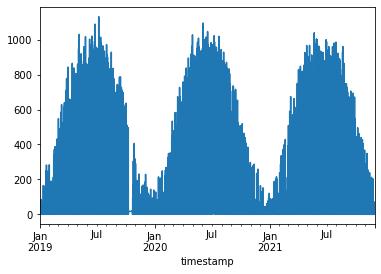

In [12]:
radiation = to_timeseries(data[["timestamp","radiation_flux"]])
radiation.plot()
plt.show()

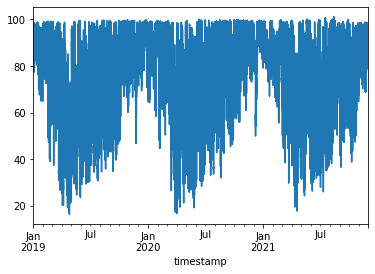

In [13]:
humidity = to_timeseries(data[["timestamp","humidity"]])
humidity.plot()
plt.show()

### Filter shorter periods

In [14]:
radiation2021 = radiation.loc['2021-01-01 00:00':]
humidity2021 = humidity.loc['2021-01-01 00:00':]


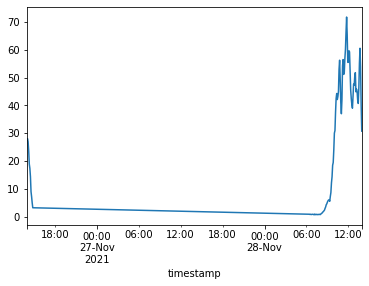

In [15]:
radiation.loc['2021-11-26 14:00':'2021-11-28 13:55'].plot()
plt.show()

In [16]:
data_test = get_weather_data(2021,12,1,2021,12,9)
data_test = cleansing(data_test)
radiation_test = to_timeseries(data_test[["timestamp","radiation_flux"]])

# ARIMA

## About

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.
A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

## Autocorrelation

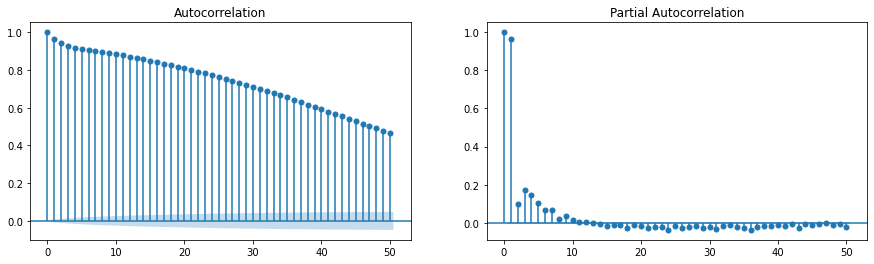

In [17]:
fig, axes = plt.subplots(1,2,figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(radiation2021,lags=50,ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(radiation2021,lags=50,ax=axes[1])


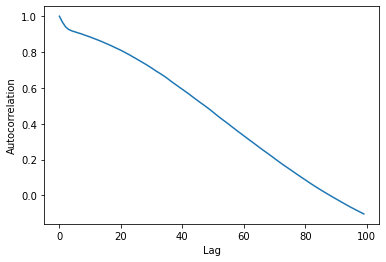

In [18]:
AC = []
for l in range(100): AC.append(radiation2021.autocorr(lag=l))
plt.plot(range(100),AC)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

## Train and predict

In [19]:
ct = datetime.now()
t1 = str(ct - timedelta(days=8))[:15]+"0"
t2 = str(ct - timedelta(days=1))[:15]+"0"
t1,t2


('2021-12-04 00:40', '2021-12-11 00:40')

In [20]:
model = ARIMA(radiation2021, order=(1,0,1))
model_fit = model.fit() 

In [21]:
pred_rad = model_fit.predict()[144:168]
len(pred_rad)

24

In [22]:
test_rad = radiation_test[144:168]

In [23]:
rmse = np.sqrt(mean_squared_error(test_rad, pred_rad))
rmse

9.429750983671592

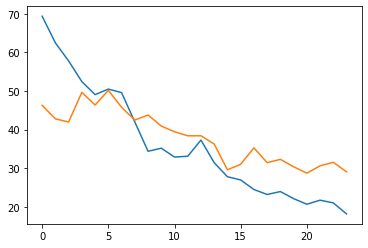

In [24]:
plt.plot(range(len(pred_rad)),pred_rad.values)
plt.plot(range(len(test_rad)),test_rad.values)
plt.show()

In [25]:
model = ARIMA(radiation2021, order=(1,0,2))
model_fit = model.fit() 

In [26]:
pred_rad = model_fit.predict()[144:168]
len(pred_rad)

24

In [27]:
test_rad = radiation_test[144:168]

In [28]:
rmse = np.sqrt(mean_squared_error(test_rad, pred_rad))
rmse

9.540805636485212

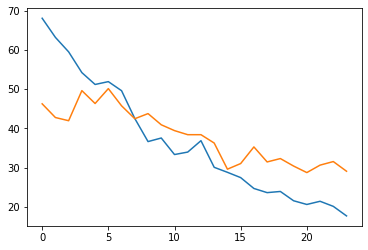

In [29]:
plt.plot(range(len(pred_rad)),pred_rad.values)
plt.plot(range(len(test_rad)),test_rad.values)
plt.show()

In [30]:
radiation2021nov = radiation.loc['2021-11-01 00:00':]